# Varied audience model

In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from model_varied_audience import *

sns.set_context('talk')

## First, look at how model looks like with toy params

- In-group members: vary from 0 to 4
- Out-group members: powers of 2 up to 16

In [2]:
ns_ingroup = [0, 1, 2, 3, 4]
ns_outgroup = [0, 1, 2, 4, 8, 16]

# list of [ingroup, outgroup] possibilites
ns = [[i, o] for i in ns_ingroup for o in ns_outgroup]


Generate model predictions, populate into a dataframe

In [3]:
rows = []
for n in ns: 
    pred_refer = speaker(n_ingroup=n[0], n_outgroup=n[1], alpha=2, w_r=1, w_s=0, w_c=0.05)
    rows.append({'goal': 'refer', 'n_ingroup': n[0], 'n_outgroup': n[1], 'p_earlier': pred_refer[0]})

    pred_social = speaker(n_ingroup=n[0], n_outgroup=n[1], alpha=2, w_r=0.1, w_s=1, w_c=0.05)
    rows.append({'goal': 'social', 'n_ingroup': n[0], 'n_outgroup': n[1], 'p_earlier': pred_social[0]})

df = pd.DataFrame(rows)

# remove jax stuff
df['p_earlier'] = df['p_earlier'].apply(lambda x: x.item())

In [4]:
df

,goal,n_ingroup,n_outgroup,p_earlier
0,refer,0,0,0.475021
1,social,0,0,0.475021
2,refer,0,1,0.869892
3,social,0,1,0.524979
4,refer,0,2,0.980160
5,social,0,2,0.574443
6,refer,0,4,0.999629
7,social,0,4,0.668188
8,refer,0,8,1.000000
9,social,0,8,0.817575


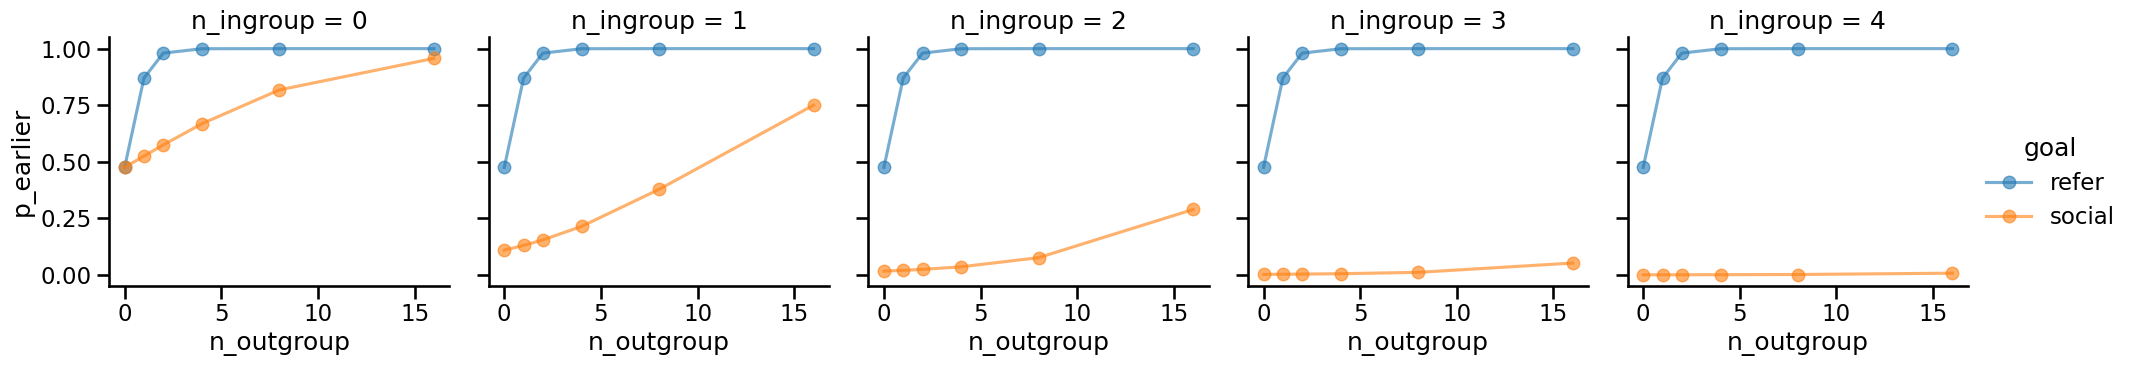

In [5]:
g = sns.FacetGrid(df, col='n_ingroup', hue="goal", col_wrap=5, height=4)
g.map(plt.plot, 'n_outgroup', 'p_earlier', marker='o', alpha= 0.6)
g.add_legend()

Plots with proportion

In [6]:
df['n_total'] = df['n_ingroup'] + df['n_outgroup']
df['prop_ingroup'] = df['n_ingroup'] / df['n_total']

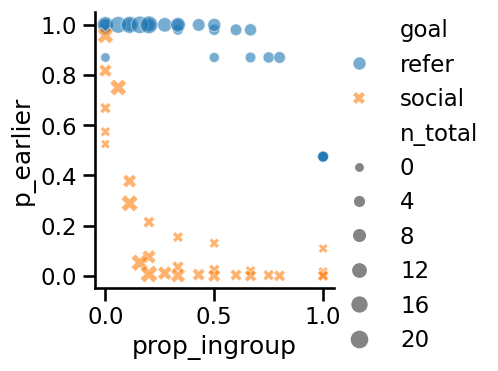

In [7]:
g = sns.relplot(data=df, x='prop_ingroup', y='p_earlier', hue='goal', style="goal", size="n_total", alpha=0.6, height=4)

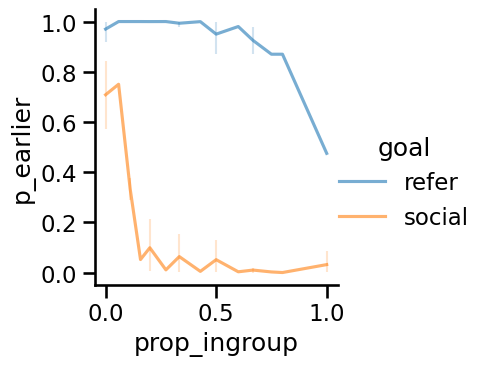

In [8]:
g = sns.relplot(data=df, x='prop_ingroup', y='p_earlier', hue='goal', kind='line', alpha=0.6, height=4)

## Load data and fit model

In [9]:
data = pd.read_csv("../data/3pp/varied_audience/selection_trials_clean.csv"
                   ).rename(columns={"item_id": "tangram_set"})

# Omit the "social" goal when there are no in-group members
# data = data.loc[~((data["goal"] == "social") & (data["n_ingroup"] == 0))]

data.loc[data["response.earlier"] == "earlier", "response.earlier"] = 1
data.loc[data["response.earlier"] == "later", "response.earlier"] = 0
data["response.earlier"] = data["response.earlier"].astype(int)

Get the relevant stuff from the data

In [10]:
refer_mask = data["goal"] == "refer"
social_mask = data["goal"] == "social"

# Convert columns for the 'refer' subset
n_in_refer = jnp.array(data.loc[refer_mask, "n_ingroup"].values)
n_out_refer = jnp.array(data.loc[refer_mask, "n_outgroup"].values)
resp_refer = jnp.array(data.loc[refer_mask, "response.earlier"].values)

# Convert columns for the 'social' subset
n_in_social = jnp.array(data.loc[social_mask, "n_ingroup"].values)
n_out_social = jnp.array(data.loc[social_mask, "n_outgroup"].values)
resp_social = jnp.array(data.loc[social_mask, "response.earlier"].values)

In [11]:
@jax.jit
def speaker_refer(n_ingroup, n_outgroup, w_r, w_c):
    return speaker(
        n_ingroup=n_ingroup,
        n_outgroup=n_outgroup,
        alpha=1,
        w_r=0.1 + w_r,
        w_s=0,
        w_c=w_c,
    )[0]

@jax.jit
def speaker_social(n_ingroup, n_outgroup, w_s, w_c):
    return speaker(
        n_ingroup=n_ingroup,
        n_outgroup=n_outgroup,
        alpha=1,
        w_r=0.1,
        w_s=w_s,
        w_c=w_c,
    )[0]

# functions for generating predictions over the whole dataset
speaker_refer_vmap = jax.vmap(speaker_refer, in_axes=(0, 0, None, None))
speaker_social_vmap = jax.vmap(speaker_social, in_axes=(0, 0, None, None))

Compute preds on the whole dataset

In [12]:
@jax.jit
def predict_all(n_in_refer, n_out_refer, n_in_social, n_out_social, w_r, w_s, w_c):
    preds_refer = speaker_refer_vmap(n_in_refer, n_out_refer, w_r, w_c)
    preds_social = speaker_social_vmap(n_in_social, n_out_social, w_s, w_c)
    return preds_refer, preds_social

@jax.jit
def NLL_all(n_in_refer, n_out_refer, n_in_social, n_out_social, resp_refer, resp_social, w_r, w_s, w_c):
    preds_refer, preds_social = predict_all(n_in_refer, n_out_refer, n_in_social, n_out_social, w_r, w_s, w_c)
    eps = 1e-7
    preds_refer_clipped = jnp.clip(preds_refer, eps, 1 - eps)
    preds_social_clipped = jnp.clip(preds_social, eps, 1 - eps)
    nll_refer = -jnp.sum(resp_refer * jnp.log(preds_refer_clipped) + (1 - resp_refer) * jnp.log(1 - preds_refer_clipped))
    nll_social = -jnp.sum(resp_social * jnp.log(preds_social_clipped) + (1 - resp_social) * jnp.log(1 - preds_social_clipped))
    return nll_refer + nll_social

In [13]:
def fit_params(params_list, n_in_refer, n_out_refer, n_in_social, n_out_social, resp_refer, resp_social):
    nlls = []
    for params in tqdm(params_list):
        nll = NLL_all(n_in_refer, n_out_refer, n_in_social, n_out_social, resp_refer, resp_social, *params)
        nlls.append(nll)
    
    nlls = jnp.array(nlls)
    min_idx = jnp.argmin(nlls)
    best_params = params_list[min_idx]
    best_nll = nlls[min_idx]
    return best_params, best_nll

In [14]:
w_rs = np.arange(0, 5, 0.1)
w_ss = np.arange(0, 5, 0.1)
w_cs = np.arange(0, 5, 0.1)
params_list = [(w_r, w_s, w_c) for w_r in w_rs for w_s in w_ss for w_c in w_cs]

In [15]:
best_params_social, best_nll_social = fit_params(
    params_list=params_list,
    n_in_refer=n_in_refer,
    n_out_refer=n_out_refer,
    n_in_social=n_in_social,
    n_out_social=n_out_social,
    resp_refer=resp_refer,
    resp_social=resp_social,
)

100%|██████████| 125000/125000 [00:04<00:00, 30818.35it/s]


In [16]:
best_params_social, best_nll_social

((0.1, 0.30000000000000004, 0.0), Array(990.3479, dtype=float32))

In [17]:
best_w_r, best_w_s, best_w_c = best_params_social

Generate model predictions using `best_params`

- In-group members: vary from 0 to 4
- Out-group members: powers of 2 up to 16

In [18]:
ns_ingroup = [0, 1, 2, 3, 4]
ns_outgroup = [0, 1, 2, 4, 8, 16]

# list of [ingroup, outgroup] possibilites
ns = [[i, o] for i in ns_ingroup for o in ns_outgroup]


In [19]:
rows = []
for n in ns: 
    pred_refer = speaker(n_ingroup=n[0], n_outgroup=n[1], alpha=1, w_r=0.1 + best_w_r, w_s=0, w_c=best_w_c)
    rows.append({'goal': 'refer', 'n_ingroup': n[0], 'n_outgroup': n[1], 'p_earlier': pred_refer[0]})

    pred_social = speaker(n_ingroup=n[0], n_outgroup=n[1], alpha=1, w_r=0.1, w_s=best_w_s, w_c=best_w_c)
    rows.append({'goal': 'social', 'n_ingroup': n[0], 'n_outgroup': n[1], 'p_earlier': pred_social[0]})

df = pd.DataFrame(rows)

# remove jax stuff
df['p_earlier'] = df['p_earlier'].apply(lambda x: x.item())

Text(0.5, 1.2, 'Best-fitting model predictions\nBest $w_r= 0.1$, $w_s= 0.3$, $w_c= 0.0$, NLL=990.348')

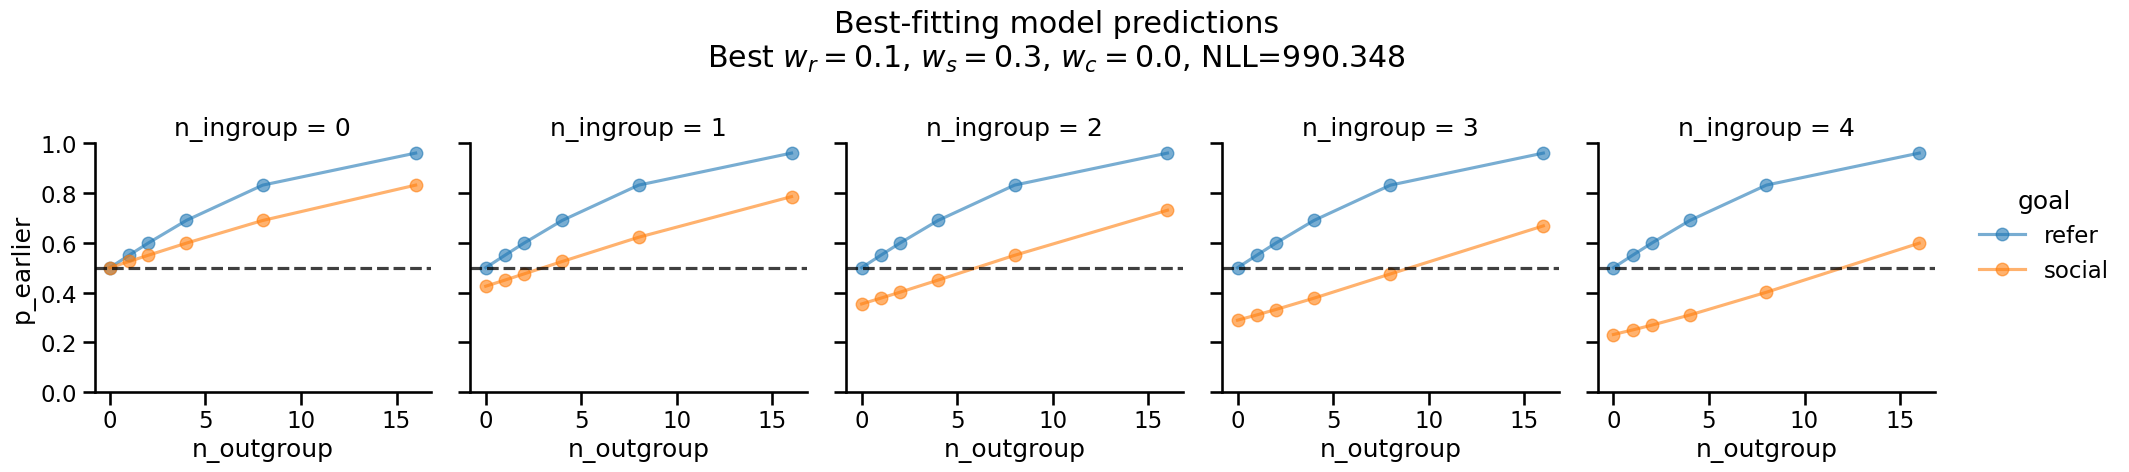

In [20]:
g = sns.FacetGrid(df, col='n_ingroup', hue="goal", col_wrap=5, height=4)
g.map(plt.plot, 'n_outgroup', 'p_earlier', marker='o', alpha= 0.6)
g.add_legend()
g.map(plt.axhline, y=0.5, ls='--', color='black', alpha=0.5)
g.set(ylim=(0, 1))
g.figure.suptitle('Best-fitting model predictions\nBest $w_r= {:.1f}$, $w_s= {:.1f}$, $w_c= {:.1f}$, NLL={:.3f}'.format(best_w_r, best_w_s, best_w_c, best_nll_social), y=1.2)

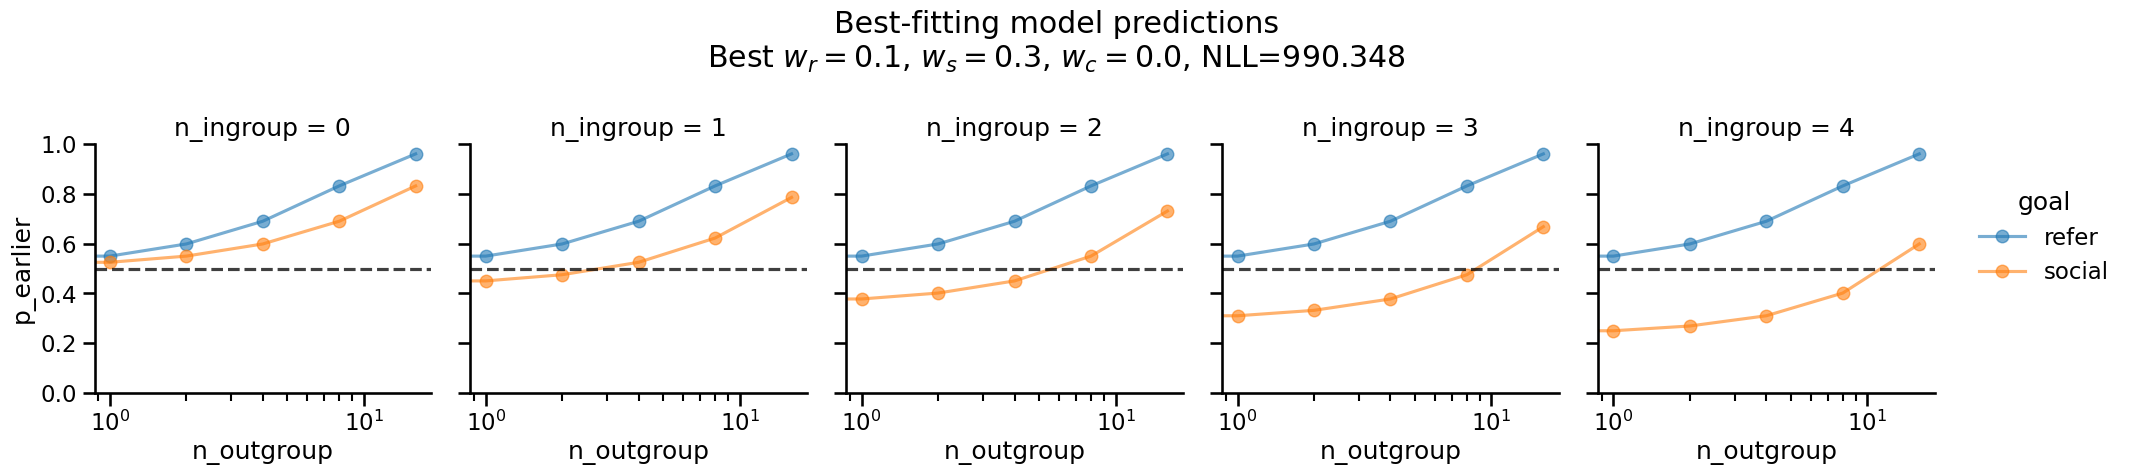

In [21]:
g = sns.FacetGrid(df, col='n_ingroup', hue="goal", col_wrap=5, height=4)
g.map(plt.plot, 'n_outgroup', 'p_earlier', marker='o', alpha=0.6)
g.add_legend()
g.map(plt.axhline, y=0.5, ls='--', color='black', alpha=0.5)
g.set(ylim=(0, 1), xscale="log")
g.figure.suptitle('Best-fitting model predictions\nBest $w_r= {:.1f}$, $w_s= {:.1f}$, $w_c= {:.1f}$, NLL={:.3f}'.format(best_w_r, best_w_s, best_w_c, best_nll_social), y=1.2)
plt.show()

What if we didn't have social utility?

In [22]:
w_rs = np.arange(0, 5, 0.1)
w_ss = np.array([0])
w_cs = np.arange(0, 5, 0.1)
params_list = [(w_r, w_s, w_c) for w_r in w_rs for w_s in w_ss for w_c in w_cs]

In [23]:
best_params_no_social, best_nll_no_social = fit_params(
    params_list=params_list,
    n_in_refer=n_in_refer,
    n_out_refer=n_out_refer,
    n_in_social=n_in_social,
    n_out_social=n_out_social,
    resp_refer=resp_refer,
    resp_social=resp_social,
)

100%|██████████| 2500/2500 [00:00<00:00, 16775.50it/s]


In [24]:
best_params_no_social, best_nll_no_social

((0.2, 0, 0.5), Array(1029.5239, dtype=float32))

In [25]:
best_w_r, best_w_s, best_w_c = best_params_no_social

Generate model predictions using `best_params`

In [26]:
rows = []
for n in ns: 
    pred_refer = speaker(n_ingroup=n[0], n_outgroup=n[1], alpha=1, w_r=0.1 + best_params_no_social[0], w_s=0, w_c=best_params_no_social[2])
    rows.append({'goal': 'refer', 'n_ingroup': n[0], 'n_outgroup': n[1], 'p_earlier': pred_refer[0]})

    pred_social = speaker(n_ingroup=n[0], n_outgroup=n[1], alpha=1, w_r=0.1, w_s=best_params_no_social[1], w_c=best_params_no_social[2])
    rows.append({'goal': 'social', 'n_ingroup': n[0], 'n_outgroup': n[1], 'p_earlier': pred_social[0]})

df = pd.DataFrame(rows)

# remove jax stuff
df['p_earlier'] = df['p_earlier'].apply(lambda x: x.item())

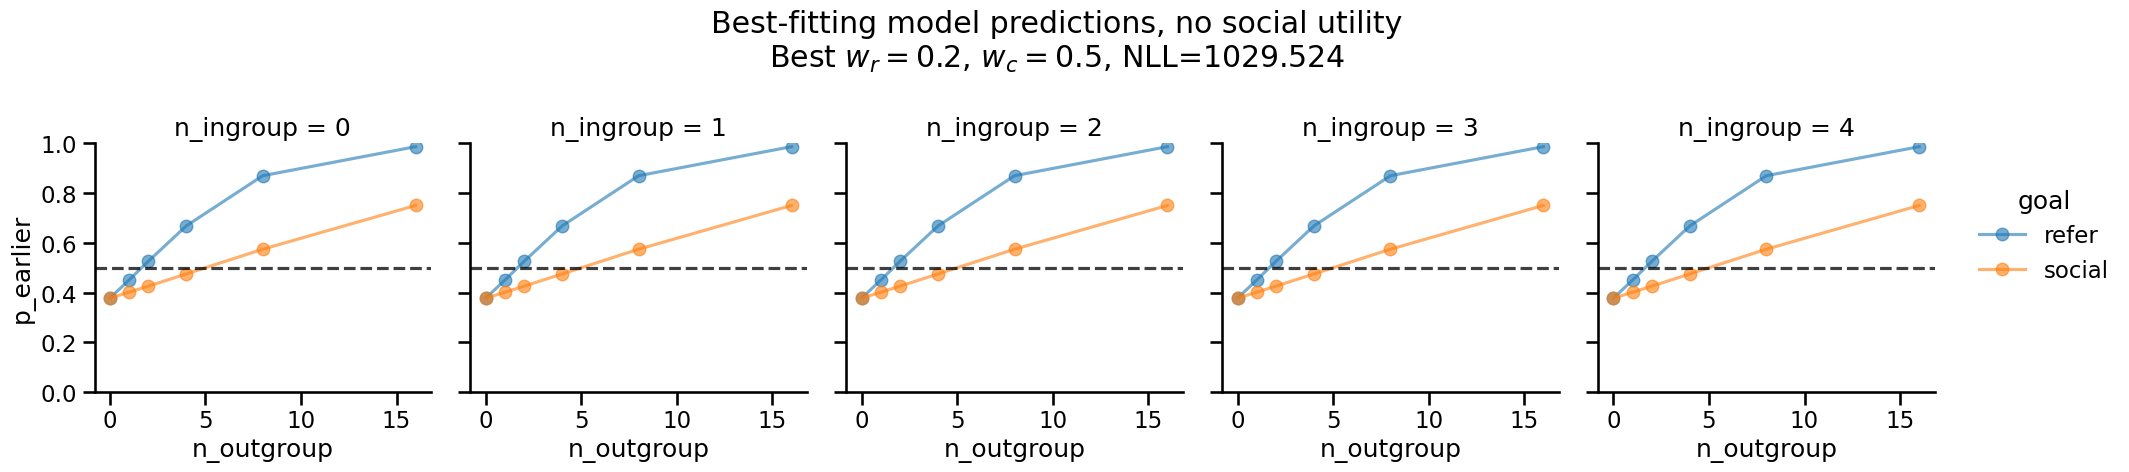

In [27]:
g = sns.FacetGrid(df, col='n_ingroup', hue="goal", col_wrap=5, height=4)
g.map(plt.plot, 'n_outgroup', 'p_earlier', marker='o', alpha= 0.6)
g.add_legend()
g.map(plt.axhline, y=0.5, ls='--', color='black', alpha=0.5)
g.set(ylim=(0, 1))
g.figure.suptitle('Best-fitting model predictions, no social utility\nBest $w_r= {:.1f}$, $w_c= {:.1f}$, NLL={:.3f}'.format(best_w_r, best_w_c, best_nll_no_social), y=1.2)
plt.show()

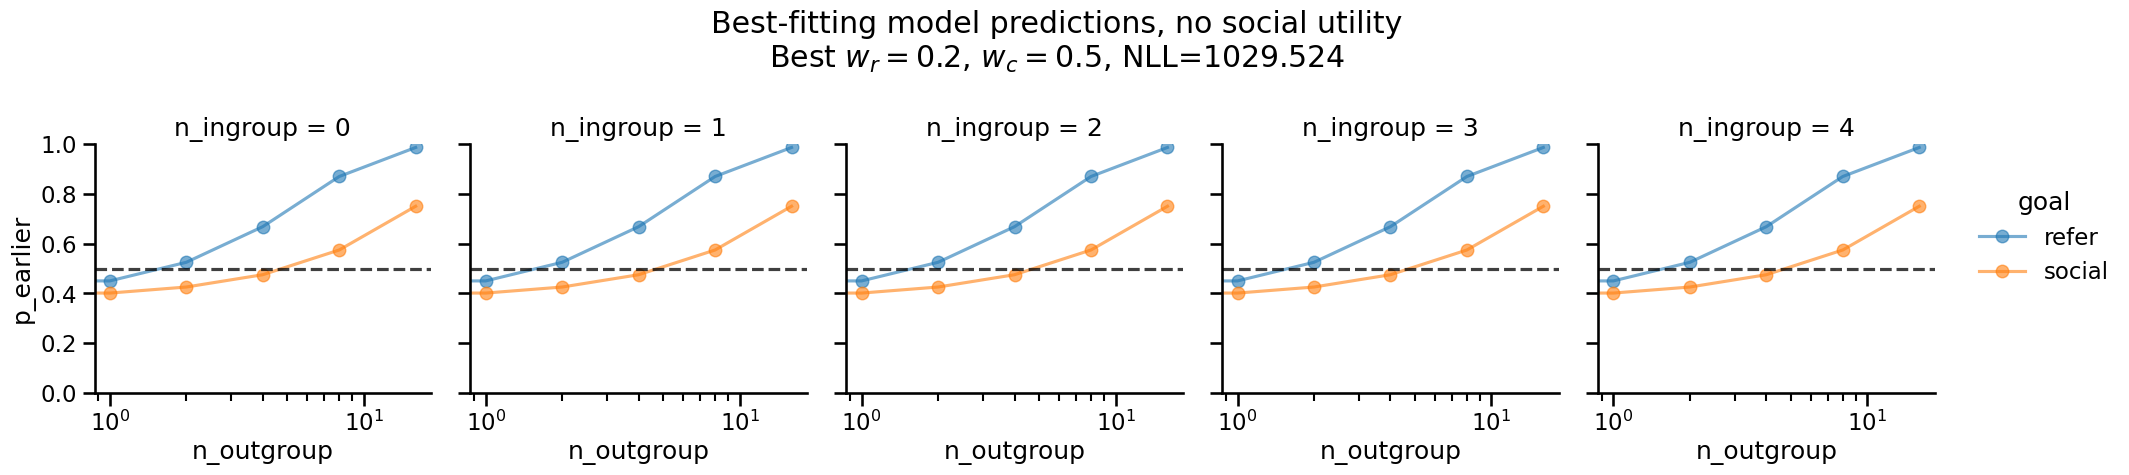

In [28]:
g = sns.FacetGrid(df, col='n_ingroup', hue="goal", col_wrap=5, height=4)
g.map(plt.plot, 'n_outgroup', 'p_earlier', marker='o', alpha=0.6)
g.add_legend()
g.map(plt.axhline, y=0.5, ls='--', color='black', alpha=0.5)
g.set(ylim=(0, 1), xscale="log")
g.figure.suptitle('Best-fitting model predictions, no social utility\nBest $w_r= {:.1f}$, $w_c= {:.1f}$, NLL={:.3f}'.format(best_w_r, best_w_c, best_nll_no_social), y=1.2)
plt.show()

Likelihood ratio test

In [29]:
from scipy.stats import chi2
lr_stat = 2 * (best_nll_no_social - best_nll_social)
df = 1
p_value = 1 - chi2.cdf(lr_stat, df)
lr_stat, p_value

(Array(78.35205, dtype=float32), 0.0)